**Install Libraries**

In [ ]:
!pip install transformers datasets torch
!pip install emoji
!pip install swifter
!pip install --upgrade datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

**Import Library**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import emoji
import nltk
import torch
import os
import datasets

import swifter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from nltk.stem import WordNetLemmatizer
from transformers import TrainingArguments, Trainer, EvalPrediction
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from datasets import load_from_disk

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Cek GPU**

In [ ]:
print("GPU tersedia:", torch.cuda.is_available())
print("Jumlah GPU:", torch.cuda.device_count())
print("Nama GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Tidak tersedia")

GPU tersedia: True
Jumlah GPU: 1
Nama GPU: Tesla T4


**Inisialisasi Fungsi**

In [ ]:
lemmatizer = WordNetLemmatizer()

**Load Dataset**

In [ ]:
# @title Paths for TinyBERT Model and Datasets
# PATH untuk menyimpan model TinyBERT (ubah ke path yang lebih umum di Colab)
MODEL_SAVE_PATH = "/content/models/tinybert"
train_path = "/content/datasets/train_dataset_tinybert" # Juga gunakan path umum
val_path = "/content/datasets/val_dataset_tinybert"
test_path = "/content/datasets/test_dataset_tinybert"

# Pastikan direktori ada
import os
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs("/content/datasets", exist_ok=True) # Buat direktori untuk dataset

Mounted at /content/drive


# **Exploratory Data Anakysis (EDA)**

In [ ]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [ ]:
print(df.isnull().sum())

app_id               0
app_name        183234
review_text       7305
review_score         0
review_votes         0
dtype: int64


review_score
 1    81.974959
-1    18.025041
Name: proportion, dtype: float64


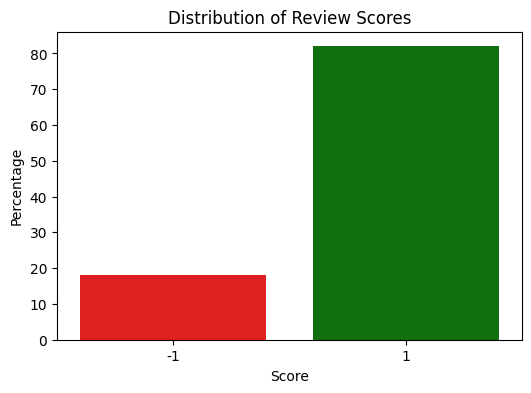

In [ ]:
score_counts = df['review_score'].value_counts(normalize=True) * 100
print(score_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=score_counts.index, y=score_counts.values, palette=['red', 'green'])
plt.xlabel('Score')
plt.ylabel('Percentage')
plt.title('Distribution of Review Scores')
plt.show()

# **Data Preprocessing**

In [ ]:
# Cek jumlah data sebelum di drop
print(df.shape)

# Drop data dengan review_text yang hilang
df.dropna(subset=['review_text'], inplace=True)

# Drop app_name, app_id, dan review_votes karena tidak diperlukan
df.drop(columns=['app_name', 'app_id', 'review_votes'], inplace=True)

# Cek jumlah data sesudah di drop
print(df.shape)

(6417106, 5)
(6409801, 2)


In [ ]:
import re

def remove_ascii_art(text):
    # Remove lines that mostly consist of box/line characters
    return "\n".join([line for line in text.split("\n") if not re.match(r'^[\s█▀▄░▒▓─━╱╲═║╔╗╝╚╦╩╬]+$', line)])

# Example usage
df['review_text'] = df['review_text'].apply(remove_ascii_art)

In [ ]:
def clean_symbols(text):
    return re.sub(r'[^\w\s.,!?\'"-]', '', text)

df['review_text'] = df['review_text'].apply(clean_symbols)

In [ ]:
print(df.isnull().sum())

review_text     0
review_score    0
dtype: int64


In [ ]:
# Drop rows where review_text is 'Early Access Review'
df = df[df['review_text'].str.strip() != "Early Access Review"]

# Cek jumlah data sesudah di drop
print(df.shape)
print(df.isnull().sum())


(5385114, 2)
review_text     0
review_score    0
dtype: int64


In [ ]:
# Ambil 20 ribu review positif dan review negatif secara acak
df_positive = df[df['review_score'] == 1].sample(n=20000, random_state=42)
df_negative = df[df['review_score'] == -1].sample(n=20000, random_state=42)

# Gabungkan kedua subset
df_sampled = pd.concat([df_positive, df_negative])

# Shuffle data
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Cek distribusi akhir
print(df_sampled['review_score'].value_counts(normalize=True) * 100)
print(df_sampled.shape)

review_score
-1    50.0
 1    50.0
Name: proportion, dtype: float64
(40000, 2)


In [ ]:
df_sampled.head(50)

,review_text,review_score
0,Wouldnt recomened this game ps2 version way be...,-1
1,This Is The Only Game That Actually Makes Me R...,1
2,No real updates in years. best game ever. 100,-1
3,You need this game in your life. Buy it. Buy i...,1
4,Somebody gift it to me and i feel scamed,-1
5,"bought played missions to main hub town, now i...",-1
6,To sum up my feelings. If they ask what is the...,1
7,Braveland is a fun game that I would reccomend...,-1
8,One of the greatest games ever created and one...,1
9,"Dumbed down UI, units, and buildings from prev...",-1


In [ ]:
slang_dict = {
    "gg": "good game",
    "wp": "well played",
    "glhf": "good luck have fun",
    "nt": "nice try",
    "ez": "easy",
    "brb": "be right back",
    "afk": "away from keyboard",
    "np": "no problem",
    "ty": "thank you",
    "thx": "thanks",
    "idk": "I don't know",
    "idc": "I don't care",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "fyi": "for your information",
    "tbh": "to be honest",
    "smh": "shaking my head",
    "lmao": "laughing my ass off",
    "lol": "laugh out loud",
    "rofl": "rolling on the floor laughing",
    "omg": "oh my god",
    "wtf": "what the fuck",
    "wth": "what the hell",
    "ikr": "I know right",
    "tfw": "that feeling when",
    "tgif": "thank god it's friday",
    "bff": "best friends forever",
    "hmu": "hit me up",
    "dm": "direct message",
    "irl": "in real life",
    "ftw": "for the win",
    "nvm": "never mind",
    "jk": "just kidding",
    "ggwp": "good game well played",
    "gl": "good luck",
    "hf": "have fun",
    "roflmao": "rolling on the floor laughing my ass off",
    "stfu": "shut the fuck up",
    "gtg": "got to go",
    "ttyl": "talk to you later",
    "asap": "as soon as possible",
    "g2g": "got to go",
    "wyd": "what are you doing",
    "wya": "where are you at",
    "tho": "though",
    "u": "you",
    "r": "are",
    "ur": "your",
    "bday": "birthday",
    "pls": "please",
    "ppl": "people",
    "thx": "thanks",
    "cuz": "because",
    "gr8": "great",
    "luv": "love",
    "yolo": "you only live once",
    "fomo": "fear of missing out",
    "sry": "sorry",
    "np": "no problem",
    "jk": "just kidding",
    "xoxo": "hugs and kisses",
    "ily": "I love you",
    "idgaf": "I don't give a fuck",
    "lmfao": "laughing my fucking ass off",
    "fml": "fuck my life",
    "ggnoob": "good game, noob",
    "rekt": "wrecked",
    "noob": "newbie",
    "nerf": "make weaker",
    "buff": "make stronger",
    "op": "overpowered",
    "meta": "most effective tactic available",
    "fps": "frames per second",
    "rpg": "role-playing game",
    "mmo": "massively multiplayer online",
    "npc": "non-playable character",
    "pvp": "player versus player",
    "pve": "player versus environment",
    "af": "as fuck",
    "oof": "expression of pain or disappointment",
    "sus": "suspicious",
    "pog": "play of the game",
    "kek": "laughing",
    "xd": "laughing face",
    "lel": "laughing",
    "smol": "small and cute",
    "based": "confident and unapologetic",
    "copium": "coping mechanism",
    "ratio": "more replies than likes",
    "goat": "greatest of all time",
    "cap": "lie",
    "no cap": "no lie",
    "bussin": "very good",
    "drip": "cool outfit",
    "simp": "obsessive admirer",
    "chad": "confident and attractive male",
    "karen": "entitled and demanding person",
    "malding": "mad and balding",
    "cringe": "embarrassing",
    "vibe": "mood or atmosphere",
    "stan": "obsessive fan",
    "dogwater": "bad, worthless",
    "sweaty": "tryhard",
    "clutch": "decisive and important play",
    "dps": "damage per second",
    "gg ez": "good game, easy",
    "troll": "deliberately annoying or misleading",
    "toxic": "overly negative or aggressive",
    "smurf": "high-rank player using a low-rank account",
    "lag": "slow network response",
    "ping": "network latency",
    "adc": "attack damage carry",
    "tank": "absorbs damage",
    "jungler": "roams and kills jungle monsters",
    "mid": "middle lane player",
    "bot": "bottom lane player",
    "top": "top lane player",
    "hard carry": "player who carries the team",
    "inting": "intentionally feeding",
    "feeding": "dying repeatedly to enemies",
    "ks": "kill steal",
    "cs": "creep score",
    "farm": "killing minions or jungle monsters",
    "snowball": "gaining a lead and increasing it",
    "gank": "ambush in-game",
    "pepega": "stupid or clueless",
    "monkaS": "scary or intense moment",
    "feelsbadman": "sadness",
    "feelsgoodman": "happiness",
    "weeb": "anime enthusiast",
    "otaku": "dedicated anime or gaming fan",
    "baka": "idiot"
}

In [ ]:
def preprocess(text):
  text = emoji.demojize(text, delimiters=(" ", " ")) # Mengubah emoji menjadi kata
  words = text.split()
  words = [slang_dict.get(word.lower(), word) for word in words] # Mengubah kata slang menjadi kata baku
  words = [lemmatizer.lemmatize(word) for word in words] # Mengubah kata menjadi kata dasar

  return ' '.join(words)

In [ ]:
# Jika file belum ada, lakukan preprocessing dan simpan
if not os.path.exists("/content/drive/MyDrive/Datasets/preprocessed_reviews.csv"):
  print("Preprocessing dataset...")
  df_sampled['review_text'] = df_sampled['review_text'].swifter.apply(preprocess)

  # Mengubah label -1 menjadi 0
  df_sampled["review_score"] = df_sampled["review_score"].replace({-1: 0, 1: 1}).astype(int)

  df_sampled.to_csv("/content/drive/MyDrive/Datasets/preprocessed_reviews.csv", index=False)

else:
  df_sampled = pd.read_csv("/content/drive/MyDrive/Datasets/preprocessed_reviews.csv")
  print("Dataset is loaded completely")

Preprocessing dataset...


Pandas Apply:   0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
del df
import gc; gc.collect()

2868

# **Modeling**

In [ ]:
# Bagi data menjadi training (80%), validation (10%), dan testing (10%)
train_data, test_data = train_test_split(df_sampled, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)  # Masing-masing 10%

# Konversi ke Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [ ]:
# Metrics Function
def compute_metrics(pred: EvalPrediction):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [ ]:
# Pindahkan model ke GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

**TinyBERT**

In [ ]:
# Tokenization menggunakan map (lebih cepat daripada loop biasa)
def tokenize_function_tinybert(examples):
    return tokenizer_tinybert(
        examples["review_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Tokenisasi dan formatting semua split
def prepare_dataset_tinybert(ds):
    ds = ds.map(tokenize_function_tinybert, batched=True)
    if "review_text" in ds.column_names:
        ds = ds.remove_columns(["review_text"])
    if "__index_level_0__" in ds.column_names:
        ds = ds.remove_columns(["__index_level_0__"])
    ds = ds.rename_column("review_score", "labels")
    ds = ds.cast_column("labels", datasets.Value("int64"))

    ds.set_format("torch")
    return ds

In [ ]:
# @title Paths for TinyBERT Model and Datasets
MODEL_SAVE_PATH = "/content/models/tinybert"
train_path = "/content/datasets/train_dataset_tinybert" # Juga gunakan path umum
val_path = "/content/datasets/val_dataset_tinybert"
test_path = "/content/datasets/test_dataset_tinybert"

# Pastikan direktori ada
import os
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs("/content/datasets", exist_ok=True) # Buat direktori untuk dataset

if os.path.exists(MODEL_SAVE_PATH):
    print("Model dan tokenizer sudah ada, langsung load...")

    model_tinybert = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
    tokenizer_tinybert = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)

    test_dataset_tinybert = load_from_disk(test_path)

    trainer_tinybert = Trainer(
        model=model_tinybert,
        tokenizer=tokenizer_tinybert,
        compute_metrics=compute_metrics,
    )

    # Evaluate
    test_results = trainer_tinybert.evaluate(test_dataset_tinybert)
    print("\nTest Evaluation:")
    print(test_results)

    predictions = trainer_tinybert.predict(test_dataset_tinybert)
    pred_labels = predictions.predictions.argmax(-1)
    true_labels = predictions.label_ids

    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, digits=4))

else:
    print("Model belum ada, mulai proses training...")

    MODEL_NAME_TINYBERT = "huawei-noah/TinyBERT_General_4L_312D"
    tokenizer_tinybert = AutoTokenizer.from_pretrained(MODEL_NAME_TINYBERT)
    model_tinybert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_TINYBERT, num_labels=2)

    model_tinybert.to(device)

    if all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print("Dataset sudah ada, langsung load dari Drive...")
        train_dataset_tinybert = load_from_disk(train_path)
        val_dataset_tinybert = load_from_disk(val_path)
        test_dataset_tinybert = load_from_disk(test_path)
    else:
        print("Dataset belum ada, mulai preprocessing...")
        train_dataset_tinybert = prepare_dataset_tinybert(train_dataset)
        val_dataset_tinybert = prepare_dataset_tinybert(val_dataset)
        test_dataset_tinybert = prepare_dataset_tinybert(test_dataset)

        train_dataset_tinybert.save_to_disk(train_path)
        val_dataset_tinybert.save_to_disk(val_path)
        test_dataset_tinybert.save_to_disk(test_path)

    training_args = TrainingArguments(
        output_dir=MODEL_SAVE_PATH,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=3,
        report_to="none",
    )

    trainer_tinybert = Trainer(
        model=model_tinybert,
        args=training_args,
        train_dataset=train_dataset_tinybert,
        eval_dataset=val_dataset_tinybert,
        tokenizer=tokenizer_tinybert,
        compute_metrics=compute_metrics,
    )

    # Resume from checkpoint if any
    last_checkpoint = None
    if os.path.isdir(MODEL_SAVE_PATH):
        checkpoints = [os.path.join(MODEL_SAVE_PATH_BERT, d) for d in os.listdir(MODEL_SAVE_PATH) if d.startswith("checkpoint")]
        if checkpoints:
            last_checkpoint = max(checkpoints, key=os.path.getmtime)

    if last_checkpoint:
        print(f"Resume from checkpoint: {last_checkpoint}")
        trainer_tinybert.train(resume_from_checkpoint=last_checkpoint)
    else:
        print("Start training from scratch...")
        trainer_tinybert.train()

    # Save final model & tokenizer
    model_tinybert.save_pretrained(MODEL_SAVE_PATH)
    tokenizer_tinybert.save_pretrained(MODEL_SAVE_PATH)

Model dan tokenizer sudah ada, langsung load...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Test Evaluation:
{'eval_loss': 0.31852397322654724, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8705, 'eval_f1': 0.870501003866179, 'eval_runtime': 3.9083, 'eval_samples_per_second': 1023.474, 'eval_steps_per_second': 127.934}

Classification Report:
              precision    recall  f1-score   support

           0     0.8729    0.8720    0.8725      2032
           1     0.8680    0.8689    0.8685      1968

    accuracy                         0.8705      4000
   macro avg     0.8705    0.8705    0.8705      4000
weighted avg     0.8705    0.8705    0.8705      4000



**BERT-base**

In [ ]:
# Tokenization menggunakan map (lebih cepat daripada loop biasa)
def tokenize_function_bert(examples):
    return tokenizer_bert(
        examples["review_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Tokenisasi dan formatting semua split
def prepare_dataset_bert(ds):
    ds = ds.map(tokenize_function_bert, batched=True)
    if "review_text" in ds.column_names:
        ds = ds.remove_columns(["review_text"])
    if "__index_level_0__" in ds.column_names:
        ds = ds.remove_columns(["__index_level_0__"])
    ds = ds.rename_column("review_score", "labels")
    ds = ds.cast_column("labels", datasets.Value("int64"))

    ds.set_format("torch")
    return ds

In [ ]:
# PATH
MODEL_SAVE_PATH_BERT = "/content/drive/MyDrive/Models/bert"
train_path_bert = "/content/drive/MyDrive/Datasets/train_dataset_bert"
val_path_bert = "/content/drive/MyDrive/Datasets/val_dataset_bert"
test_path_bert = "/content/drive/MyDrive/Datasets/test_dataset_bert"

# Cek apakah model sudah ada
if os.path.exists(MODEL_SAVE_PATH_BERT):
    print("Model dan tokenizer BERT sudah ada, langsung load...")

    model_bert = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH_BERT)
    tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH_BERT)

    test_dataset_bert = load_from_disk(test_path_bert)

    trainer_bert = Trainer(
        model=model_bert,
        tokenizer=tokenizer_bert,
        compute_metrics=compute_metrics,
    )

    # Evaluate
    test_results = trainer_bert.evaluate(test_dataset_bert)
    print("\nTest Evaluation:")
    print(test_results)

    predictions = trainer_bert.predict(test_dataset_bert)
    pred_labels = predictions.predictions.argmax(-1)
    true_labels = predictions.label_ids

    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, digits=4))

else:
    print("Model BERT belum ada, mulai proses training...")

    MODEL_NAME_BERT = "bert-base-uncased"
    tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME_BERT)
    model_bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_BERT, num_labels=2)

    model_bert.to(device)

    if all(os.path.exists(p) for p in [train_path_bert, val_path_bert, test_path_bert]):
        print("Dataset BERT sudah ada, langsung load dari Drive...")
        train_dataset_bert = load_from_disk(train_path_bert)
        val_dataset_bert = load_from_disk(val_path_bert)
        test_dataset_bert = load_from_disk(test_path_bert)
    else:
        print("Dataset BERT belum ada, mulai preprocessing...")
        train_dataset_bert = prepare_dataset_bert(train_dataset)
        val_dataset_bert = prepare_dataset_bert(val_dataset)
        test_dataset_bert = prepare_dataset_bert(test_dataset)

        train_dataset_bert.save_to_disk(train_path_bert)
        val_dataset_bert.save_to_disk(val_path_bert)
        test_dataset_bert.save_to_disk(test_path_bert)

    training_args_bert = TrainingArguments(
        output_dir=MODEL_SAVE_PATH_BERT,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=3,
        report_to="none",
    )

    trainer_bert = Trainer(
        model=model_bert,
        args=training_args_bert,
        train_dataset=train_dataset_bert,
        eval_dataset=val_dataset_bert,
        tokenizer=tokenizer_bert,
        compute_metrics=compute_metrics,
    )

    # Resume from checkpoint if any
    last_checkpoint = None
    if os.path.isdir(MODEL_SAVE_PATH_BERT):
        checkpoints = [os.path.join(MODEL_SAVE_PATH_BERT, d) for d in os.listdir(MODEL_SAVE_PATH_BERT) if d.startswith("checkpoint")]
        if checkpoints:
            last_checkpoint = max(checkpoints, key=os.path.getmtime)

    if last_checkpoint:
        print(f"Resume from checkpoint: {last_checkpoint}")
        trainer_bert.train(resume_from_checkpoint=last_checkpoint)
    else:
        print("Start training from scratch...")
        trainer_bert.train()

    # Save final model & tokenizer
    model_bert.save_pretrained(MODEL_SAVE_PATH_BERT)
    tokenizer_bert.save_pretrained(MODEL_SAVE_PATH_BERT)

Model dan tokenizer BERT sudah ada, langsung load...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Test Evaluation:
{'eval_loss': 0.30253514647483826, 'eval_model_preparation_time': 0.003, 'eval_accuracy': 0.8895, 'eval_f1': 0.8894990883747721, 'eval_runtime': 27.7919, 'eval_samples_per_second': 143.927, 'eval_steps_per_second': 17.991}

Classification Report:
              precision    recall  f1-score   support

           0     0.9044    0.8750    0.8894      2032
           1     0.8751    0.9045    0.8896      1968

    accuracy                         0.8895      4000
   macro avg     0.8897    0.8897    0.8895      4000
weighted avg     0.8900    0.8895    0.8895      4000



**RoBERTa-base**

In [ ]:
# Tokenization function with input check
def tokenize_function_roberta(examples):
    texts = examples["review_text"]
    # Pastikan semua elemen adalah string
    texts = [str(t) if not isinstance(t, str) else t for t in texts]
    return tokenizer_roberta(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Preprocessing function with safety checks
def prepare_dataset_roberta(ds):
    # Tokenize in batch
    ds = ds.map(tokenize_function_roberta, batched=True, batch_size=32)

    # Remove unnecessary columns
    for col in ["review_text", "__index_level_0__"]:
        if col in ds.column_names:
            ds = ds.remove_columns([col])

    # Rename and cast label column
    if "review_score" in ds.column_names:
        ds = ds.rename_column("review_score", "labels")
    ds = ds.cast_column("labels", datasets.Value("int64"))

    # Set PyTorch format
    ds.set_format("torch")
    return ds

In [ ]:
# PATH
MODEL_SAVE_PATH_ROBERTA = "/content/drive/MyDrive/Models/roberta"
train_path_roberta = "/content/drive/MyDrive/Datasets/train_dataset_roberta"
val_path_roberta = "/content/drive/MyDrive/Datasets/val_dataset_roberta"
test_path_roberta = "/content/drive/MyDrive/Datasets/test_dataset_roberta"

# Cek apakah model sudah ada
if os.path.exists(MODEL_SAVE_PATH_ROBERTA):
    print("Model dan tokenizer RoBERTa sudah ada, langsung load...")

    model_roberta = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH_ROBERTA)
    tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH_ROBERTA)

    test_dataset_roberta = load_from_disk(test_path_roberta)

    trainer_roberta = Trainer(
        model=model_roberta,
        tokenizer=tokenizer_roberta,
        compute_metrics=compute_metrics,
    )

    # Evaluate
    test_results = trainer_roberta.evaluate(test_dataset_roberta)
    print("\nTest Evaluation:")
    print(test_results)

    predictions = trainer_roberta.predict(test_dataset_roberta)
    pred_labels = predictions.predictions.argmax(-1)
    true_labels = predictions.label_ids

    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, digits=4))

else:
    print("Model RoBERTa belum ada, mulai proses training...")

    MODEL_NAME_ROBERTA = "roberta-base"
    tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME_ROBERTA)
    model_roberta = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_ROBERTA, num_labels=2)

    model_roberta.to(device)

    if all(os.path.exists(p) for p in [train_path_roberta, val_path_roberta, test_path_roberta]):
        print("Dataset RoBERTa sudah ada, langsung load dari Drive...")
        train_dataset_roberta = load_from_disk(train_path_roberta)
        val_dataset_roberta = load_from_disk(val_path_roberta)
        test_dataset_roberta = load_from_disk(test_path_roberta)
    else:
        print("Dataset RoBERTa belum ada, mulai preprocessing...")
        train_dataset_roberta = prepare_dataset_roberta(train_dataset)
        val_dataset_roberta = prepare_dataset_roberta(val_dataset)
        test_dataset_roberta = prepare_dataset_roberta(test_dataset)

        train_dataset_roberta.save_to_disk(train_path_roberta)
        val_dataset_roberta.save_to_disk(val_path_roberta)
        test_dataset_roberta.save_to_disk(test_path_roberta)

    training_args_roberta = TrainingArguments(
        output_dir=MODEL_SAVE_PATH_ROBERTA,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=False,
        metric_for_best_model="f1",
        save_total_limit=3,
        report_to="none",
    )

    trainer_roberta = Trainer(
        model=model_roberta,
        args=training_args_roberta,
        train_dataset=train_dataset_roberta,
        eval_dataset=val_dataset_roberta,
        tokenizer=tokenizer_roberta,
        compute_metrics=compute_metrics,
    )

    # Resume from checkpoint if any
    last_checkpoint = None
    if os.path.isdir(MODEL_SAVE_PATH_ROBERTA):
        checkpoints = [os.path.join(MODEL_SAVE_PATH_ROBERTA, d) for d in os.listdir(MODEL_SAVE_PATH_ROBERTA) if d.startswith("checkpoint")]
        if checkpoints:
            last_checkpoint = max(checkpoints, key=os.path.getmtime)

    if last_checkpoint:
        print(f"Resume from checkpoint: {last_checkpoint}")
        trainer_roberta.train(resume_from_checkpoint=last_checkpoint)
    else:
        print("Start training from scratch...")
        trainer_roberta.train()

    # Save final model & tokenizer
    model_roberta.save_pretrained(MODEL_SAVE_PATH_ROBERTA)
    tokenizer_roberta.save_pretrained(MODEL_SAVE_PATH_ROBERTA)

Model dan tokenizer RoBERTa sudah ada, langsung load...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Test Evaluation:
{'eval_loss': 0.5073762536048889, 'eval_model_preparation_time': 0.0053, 'eval_accuracy': 0.9, 'eval_f1': 0.899996398833222, 'eval_runtime': 28.2282, 'eval_samples_per_second': 141.702, 'eval_steps_per_second': 17.713}

Classification Report:
              precision    recall  f1-score   support

           0     0.9000    0.9035    0.9018      2032
           1     0.9000    0.8963    0.8982      1968

    accuracy                         0.9000      4000
   macro avg     0.9000    0.8999    0.9000      4000
weighted avg     0.9000    0.9000    0.9000      4000



**DeBERTa-base**

In [ ]:
# Tokenization function with input check
def tokenize_function_deberta(examples):
    texts = examples["review_text"]
    # Pastikan semua elemen adalah string
    texts = [str(t) if not isinstance(t, str) else t for t in texts]
    return tokenizer_deberta(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Preprocessing function with safety checks
def prepare_dataset_deberta(ds):
    # Tokenize in batch
    ds = ds.map(tokenize_function_deberta, batched=True, batch_size=32)

    # Remove unnecessary columns
    for col in ["review_text", "__index_level_0__"]:
        if col in ds.column_names:
            ds = ds.remove_columns([col])

    # Rename and cast label column
    if "review_score" in ds.column_names:
        ds = ds.rename_column("review_score", "labels")
    ds = ds.cast_column("labels", datasets.Value("int64"))

    # Set PyTorch format
    ds.set_format("torch")
    return ds

In [ ]:
# PATH
MODEL_SAVE_PATH_DEBERTA = "/content/drive/MyDrive/Models/deberta"
train_path_deberta = "/content/drive/MyDrive/Datasets/train_dataset_deberta"
val_path_deberta = "/content/drive/MyDrive/Datasets/val_dataset_deberta"
test_path_deberta = "/content/drive/MyDrive/Datasets/test_dataset_deberta"

# Cek apakah model sudah ada
if os.path.exists(MODEL_SAVE_PATH_DEBERTA):
    print("Model dan tokenizer DeBERTa sudah ada, langsung load...")

    model_deberta = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH_DEBERTA)
    tokenizer_deberta = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH_DEBERTA)

    test_dataset_deberta = load_from_disk(test_path_deberta)

    trainer_deberta = Trainer(
        model=model_deberta,
        tokenizer=tokenizer_deberta,
        compute_metrics=compute_metrics,
    )

    # Evaluate
    test_results = trainer_deberta.evaluate(test_dataset_deberta)
    print("\nTest Evaluation:")
    print(test_results)

    predictions = trainer_deberta.predict(test_dataset_deberta)
    pred_labels = predictions.predictions.argmax(-1)
    true_labels = predictions.label_ids

    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, digits=4))

else:
    print("Model DeBERTa belum ada, mulai proses training...")

    MODEL_NAME_DEBERTA = "microsoft/deberta-base"
    tokenizer_deberta = AutoTokenizer.from_pretrained(MODEL_NAME_DEBERTA)
    model_deberta = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_DEBERTA, num_labels=2)

    model_deberta.to(device)

    if all(os.path.exists(p) for p in [train_path_deberta, val_path_deberta, test_path_deberta]):
        print("Dataset DeBERTa sudah ada, langsung load dari Drive...")
        train_dataset_deberta = load_from_disk(train_path_deberta)
        val_dataset_deberta = load_from_disk(val_path_deberta)
        test_dataset_deberta = load_from_disk(test_path_deberta)
    else:
        print("Dataset DeBERTa belum ada, mulai preprocessing...")
        train_dataset_deberta = prepare_dataset_deberta(train_dataset)
        val_dataset_deberta = prepare_dataset_deberta(val_dataset)
        test_dataset_deberta = prepare_dataset_deberta(test_dataset)

        train_dataset_deberta.save_to_disk(train_path_deberta)
        val_dataset_deberta.save_to_disk(val_path_deberta)
        test_dataset_deberta.save_to_disk(test_path_deberta)

    training_args_deberta = TrainingArguments(
        output_dir=MODEL_SAVE_PATH_DEBERTA,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=3,
        report_to="none",
    )

    trainer_deberta = Trainer(
        model=model_deberta,
        args=training_args_deberta,
        train_dataset=train_dataset_deberta,
        eval_dataset=val_dataset_deberta,
        tokenizer=tokenizer_deberta,
        compute_metrics=compute_metrics,
    )

    # Resume from checkpoint if any
    last_checkpoint = None
    if os.path.isdir(MODEL_SAVE_PATH_DEBERTA):
        checkpoints = [os.path.join(MODEL_SAVE_PATH_DEBERTA, d) for d in os.listdir(MODEL_SAVE_PATH_DEBERTA) if d.startswith("checkpoint")]
        if checkpoints:
            last_checkpoint = max(checkpoints, key=os.path.getmtime)

    if last_checkpoint:
        print(f"Resume from checkpoint: {last_checkpoint}")
        trainer_deberta.train(resume_from_checkpoint=last_checkpoint)
    else:
        print("Start training from scratch...")
        trainer_deberta.train()

    # Save final model & tokenizer
    model_deberta.save_pretrained(MODEL_SAVE_PATH_DEBERTA)
    tokenizer_deberta.save_pretrained(MODEL_SAVE_PATH_DEBERTA)

Model dan tokenizer DeBERTa sudah ada, langsung load...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Test Evaluation:
{'eval_loss': 0.2584897577762604, 'eval_model_preparation_time': 0.0052, 'eval_accuracy': 0.90625, 'eval_f1': 0.9061583456548574, 'eval_runtime': 36.9145, 'eval_samples_per_second': 108.359, 'eval_steps_per_second': 13.545}

Classification Report:
              precision    recall  f1-score   support

           0     0.8891    0.9316    0.9099      2032
           1     0.9257    0.8801    0.9023      1968

    accuracy                         0.9062      4000
   macro avg     0.9074    0.9058    0.9061      4000
weighted avg     0.9071    0.9062    0.9062      4000



# **Evaluation**

In [ ]:
# Evaluasi setiap model dan simpan hasilnya
eval_tinybert = trainer_tinybert.evaluate(test_dataset_tinybert)
eval_bert     = trainer_bert.evaluate(test_dataset_bert)
eval_roberta  = trainer_roberta.evaluate(test_dataset_roberta)
eval_deberta  = trainer_deberta.evaluate(test_dataset_deberta)

In [ ]:
# Tampilkan hasil evaluasi dengan F1 dan Accuracy
print("📊 Evaluation Results:\n")

print("🔹 TinyBERT:")
print(f"  Accuracy: {eval_tinybert['eval_accuracy']:.4f}")
print(f"  F1 Score: {eval_tinybert['eval_f1']:.4f}\n")

print("🔹 BERT-base:")
print(f"  Accuracy: {eval_bert['eval_accuracy']:.4f}")
print(f"  F1 Score: {eval_bert['eval_f1']:.4f}\n")

print("🔹 RoBERTa-base:")
print(f"  Accuracy: {eval_roberta['eval_accuracy']:.4f}")
print(f"  F1 Score: {eval_roberta['eval_f1']:.4f}\n")

print("🔹 DeBERTa-base:")
print(f"  Accuracy: {eval_deberta['eval_accuracy']:.4f}")
print(f"  F1 Score: {eval_deberta['eval_f1']:.4f}\n")

📊 Evaluation Results:

🔹 TinyBERT:
  Accuracy: 0.8705
  F1 Score: 0.8705

🔹 BERT-base:
  Accuracy: 0.8895
  F1 Score: 0.8895

🔹 RoBERTa-base:
  Accuracy: 0.9000
  F1 Score: 0.9000

🔹 DeBERTa-base:
  Accuracy: 0.9062
  F1 Score: 0.9062



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Ambil prediksi dan label asli dari test set
def evaluate_model(trainer, test_dataset, model_name):
    result = trainer.predict(test_dataset)
    pred_labels = result.predictions.argmax(-1)
    true_labels = result.label_ids

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    matrix = confusion_matrix(true_labels, pred_labels)

    return {
        "accuracy": report["accuracy"],
        "f1": report["weighted avg"]["f1-score"],
        "report": report,
        "matrix": matrix,
        "preds": pred_labels,
        "labels": true_labels,
        "name": model_name
    }

results = [
    evaluate_model(trainer_tinybert, test_dataset_tinybert, "TinyBERT"),
    evaluate_model(trainer_bert, test_dataset_bert, "BERT-base"),
    evaluate_model(trainer_roberta, test_dataset_roberta, "RoBERTa-base"),
    evaluate_model(trainer_deberta, test_dataset_deberta, "DeBERTa-base"),
]

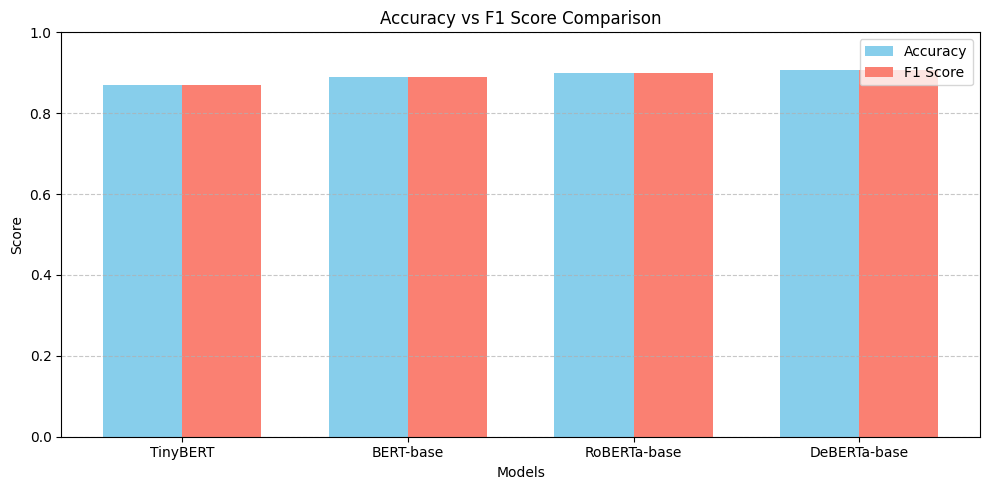

In [ ]:
model_names = [r["name"] for r in results]
accuracies = [r["accuracy"] for r in results]
f1_scores = [r["f1"] for r in results]

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(model_names))

# Accuracy
plt.bar(index, accuracies, bar_width, label='Accuracy', color='skyblue')
# F1 Score
plt.bar([i + bar_width for i in index], f1_scores, bar_width, label='F1 Score', color='salmon')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Accuracy vs F1 Score Comparison')
plt.xticks([i + bar_width / 2 for i in index], model_names)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

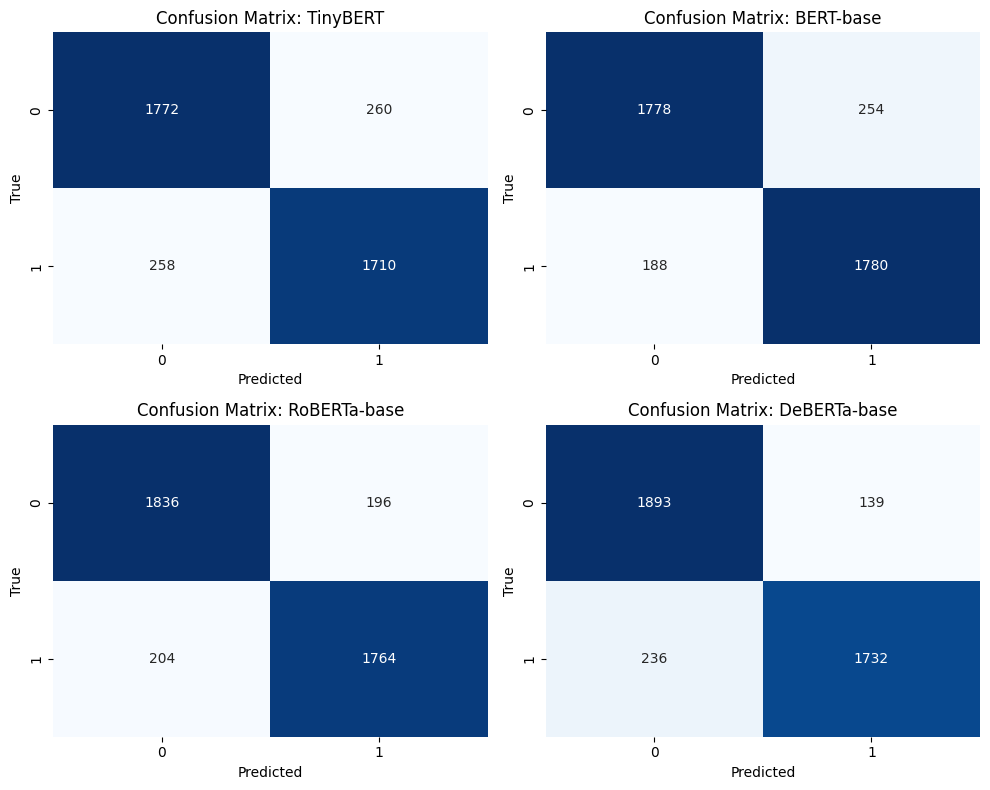

In [ ]:
n_models = len(results)
rows = 2
cols = (n_models + 1) // 2  # pastikan cukup kolom, dibulatkan ke atas jika ganjil

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

# Flatten axis array untuk mudah indexing
axes = axes.flatten()

for i, r in enumerate(results):
    sns.heatmap(r["matrix"], annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {r['name']}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Sembunyikan sisa axes jika model-nya ganjil
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()